## Import Library

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import pickle
import math
import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from scipy import optimize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## Import Pre-processed Data

In [3]:
!mkdir -p content/data
# Download all files
file_ids = [
    '1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq',  # X_train
    '1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1',  # X_train_resampled
    '1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR',  # X_test
    '1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ',  # X_test_resampled
    '1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z',  # Y_train
    '1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf',  # Y_train_resampled
    '1-CUpVhcZ6-Qop7R9Z6Btb2gEf7f0XgGy'   # Y_test
]

file_paths = [
    'content/data/X_train.pkl',
    'content/data/X_train_resampled.pkl',
    'content/data/X_test.pkl',
    'content/data/X_test_resampled.pkl',
    'content/data/Y_train.pkl',
    'content/data/Y_train_resampled.pkl',
    'content/data/Y_test.pkl'
]
for file_id, file_path in zip(file_ids, file_paths):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq
To: /content/content/data/X_train.pkl
100%|██████████| 21.4M/21.4M [00:00<00:00, 76.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1
To: /content/content/data/X_train_resampled.pkl
100%|██████████| 18.7M/18.7M [00:00<00:00, 50.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR
To: /content/content/data/X_test.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 34.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ
To: /content/content/data/X_test_resampled.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 92.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z
To: /content/content/data/Y_train.pkl
100%|██████████| 2.79M/2.79M [00:00<00:00, 214MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf
To: /content

In [4]:
# Không dùng đến các cột _scaled, mà sẽ đi chuẩn hóa ở phía dưới
X_train = pd.read_pickle('content/data/X_train.pkl')
X_train_resampled = pd.read_pickle('content/data/X_train_resampled.pkl')
X_test = pd.read_pickle('content/data/X_test.pkl')
X_test_resampled = pd.read_pickle('content/data/X_test_resampled.pkl')
y_train = pd.read_pickle('content/data/Y_train.pkl')
y_train_resampled = pd.read_pickle('content/data/Y_train_resampled.pkl')
y_test = pd.read_pickle('content/data/Y_test.pkl')

In [5]:
result_acc = []
result_recall = []
pred_time=[]

In [6]:
# X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

## 1. Logistic Regression - Thư viện

### 1.1 No resampled

In [7]:
param_grid_c = {'C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500]}
solvers = ['liblinear', 'lbfgs', 'saga']
results = {}

for solver in solvers:
    grid_search = GridSearchCV(LogisticRegression(max_iter=1000, solver=solver),
                               param_grid_c, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    results[solver] = {
        'mean_accuracy': grid_search.cv_results_['mean_test_score'],
        'std_accuracy': grid_search.cv_results_['std_test_score']
    }
    best_params = grid_search.best_params_  # Lấy tham số tốt nhất
    best_accuracy = grid_search.best_score_  # Lấy độ chính xác tốt nhất
    print(f"Solver: {solver}")
    print(f"Best C: {best_params['C']}, Best Accuracy: {best_accuracy}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Solver: liblinear
Best C: 5, Best Accuracy: 0.8531641010650522
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Solver: lbfgs
Best C: 1, Best Accuracy: 0.8531898809052173
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Solver: saga
Best C: 10, Best Accuracy: 0.8531812876251623


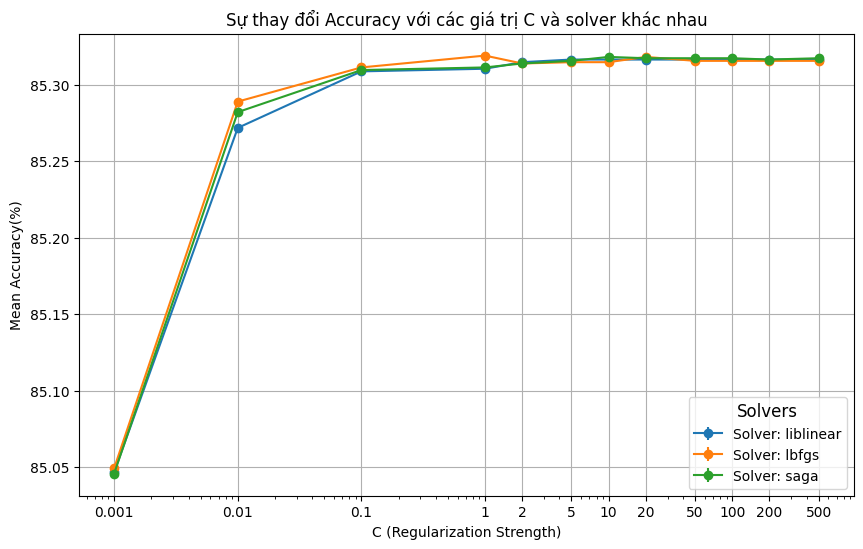

In [8]:
plt.figure(figsize=(10, 6))

for solver in solvers:
    mean_acc = results[solver]['mean_accuracy']*100
    std_acc = results[solver]['std_accuracy']
    plt.errorbar(param_grid_c['C'], mean_acc, yerr=std_acc, label=f"Solver: {solver}", fmt='o-')

plt.xscale('log')  # Biểu đồ theo log scale
plt.xticks(param_grid_c['C'], labels=[str(c) for c in param_grid_c['C']])
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Mean Accuracy(%)")
plt.title("Sự thay đổi Accuracy với các giá trị C và solver khác nhau")
plt.legend(title="Solvers", loc="best", fontsize=10, title_fontsize=12)
plt.grid()
plt.show()


In [9]:
# GridSearchCV đã tìm được siêu tham số tốt nhất
best_params = {'C': 20, 'solver': 'saga'}

# Huấn luyện lại trên tập Train với siêu tham số tốt nhất
lr = LogisticRegression(C=best_params['C'], solver=best_params['solver'], max_iter=1000)
lr.fit(X_train, y_train)

# Dự đoán trên tập Test
start_time = time.time()
y_pred = lr.predict(X_test)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")


Time to predict: 0.0068 seconds
Accuracy on Test set: 85.56%


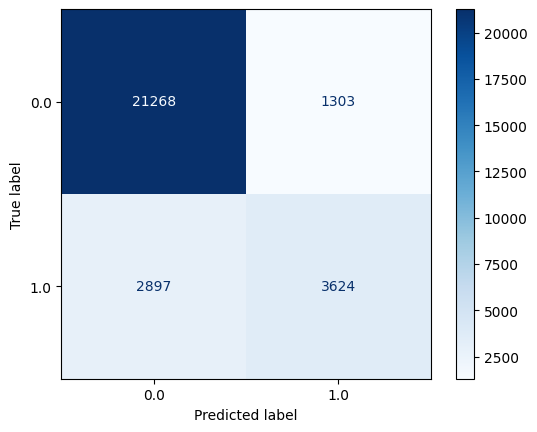

<Figure size 1200x1200 with 0 Axes>

In [10]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, cmap='Blues')
plt.figure(figsize=(12, 12))
plt.show();

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     22571
         1.0       0.74      0.56      0.63      6521

    accuracy                           0.86     29092
   macro avg       0.81      0.75      0.77     29092
weighted avg       0.85      0.86      0.85     29092



In [12]:
recall = recall_score(y_test, lr.predict(X_test), average=None)*100
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])
result_recall.append(recall)

Tỉ lệ dự đoán đúng ngày mai có mưa là  55.57429842048766
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 94.227105577954


### 1.2 Resampled

In [13]:
param_grid_c = {'C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500]}
solvers = ['liblinear', 'lbfgs', 'saga']
results = {}

for solver in solvers:
    grid_search = GridSearchCV(LogisticRegression(max_iter=1000, solver=solver),
                               param_grid_c, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)
    results[solver] = {
        'mean_accuracy': grid_search.cv_results_['mean_test_score'],
        'std_accuracy': grid_search.cv_results_['std_test_score']
    }
for solver in solvers:
    best_params = grid_search.best_params_  # Lấy tham số tốt nhất
    best_accuracy = grid_search.best_score_  # Lấy độ chính xác tốt nhất
    print(f"Solver: {solver}")
    print(f"Best C: {best_params['C']}, Best Accuracy: {best_accuracy:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Solver: liblinear
Best C: 1, Best Accuracy: 0.8053
Solver: lbfgs
Best C: 1, Best Accuracy: 0.8053
Solver: saga
Best C: 1, Best Accuracy: 0.8053


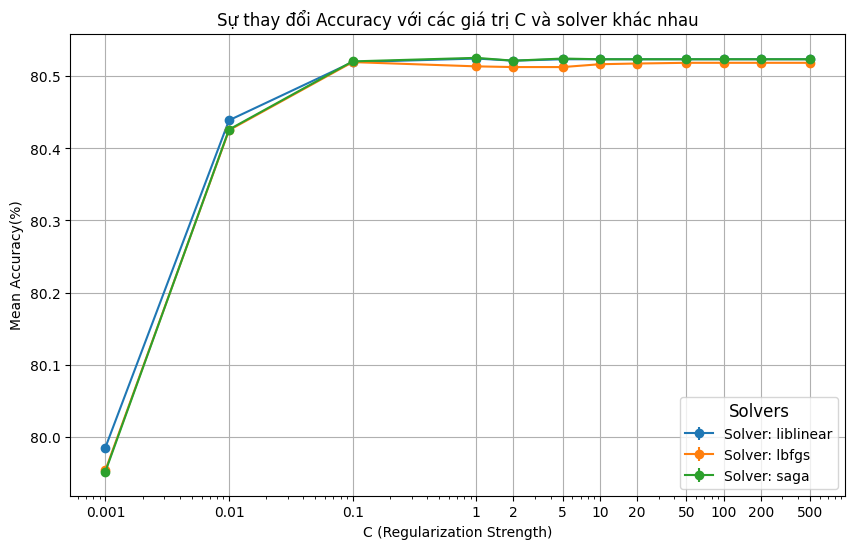

In [14]:
plt.figure(figsize=(10, 6))

for solver in solvers:
    mean_acc = results[solver]['mean_accuracy']*100
    std_acc = results[solver]['std_accuracy']
    plt.errorbar(param_grid_c['C'], mean_acc, yerr=std_acc, label=f"Solver: {solver}", fmt='o-')

plt.xscale('log')  # Biểu đồ theo log scale
plt.xticks(param_grid_c['C'], labels=[str(c) for c in param_grid_c['C']])
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Mean Accuracy(%)")
plt.title("Sự thay đổi Accuracy với các giá trị C và solver khác nhau")
plt.legend(title="Solvers", loc="best", fontsize=10, title_fontsize=12)
plt.grid()
plt.show()

In [15]:
lr_resampled = LogisticRegression(C=1, solver ='saga')
lr_resampled.fit(X_train_resampled,y_train_resampled)

# Dự đoán trên tập Test
start_time = time.time()
y_pred_resampled = lr_resampled.predict(X_test_resampled)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred_resampled) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 0.0050 seconds
Accuracy on Test set: 82.61%


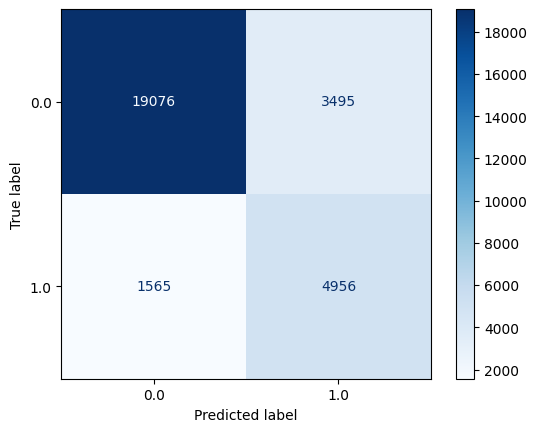

<Figure size 1200x1200 with 0 Axes>

In [16]:
ConfusionMatrixDisplay.from_estimator(lr_resampled, X_test_resampled, y_test, cmap='Blues')
plt.figure(figsize=(12, 12))
plt.show()

In [17]:
print(classification_report(y_test, y_pred_resampled))

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88     22571
         1.0       0.59      0.76      0.66      6521

    accuracy                           0.83     29092
   macro avg       0.76      0.80      0.77     29092
weighted avg       0.85      0.83      0.83     29092



In [18]:
recall = recall_score(y_test, lr_resampled.predict(X_test_resampled), average=None)*100
result_recall.append(recall)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là', recall[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là  76.00061340285232
Tỉ lệ dự đoán đúng ngày mai không có mưa là 84.51552877586283


## 2. Logistic Regression - Tự code

In [19]:
def sigmoid(z):
  z=np.array(z)
  return 1/(1+np.exp(-z))

def cost_function(theta, X, y):
    J=0
    grad=np.zeros(theta.shape)
    ttp=np.transpose(theta)
    m=np.size(X,0)
    n=np.size(X,1)
    for i in range(m):
      J+=-1/m * (y[i] * np.log(sigmoid(np.dot(ttp, X[i]))) + (1 - y[i]) * np.log(1 - sigmoid(np.dot(ttp, X[i]))))
    for j in range(n):
      sum_grad=0
      for i in range(m):
        sum_grad+=(sigmoid(np.dot(ttp, X[i]))-y[i])*X[i][j]
      grad[j]=sum_grad/m
    return J, grad

def mini_batch_gradient_descent(X, y, theta, alpha, num_iters, batch_size=1000):
    m = X.shape[0]
    J_history = []  # Để lưu lại giá trị hàm mất mát sau mỗi lần lặp
    # Biến để lưu giá trị tốt nhất
    best_cost = 10000
    best_theta = None
    for i in range(num_iters):
        # Tạo một batch ngẫu nhiên từ dữ liệu
        indices = np.random.choice(m, batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]

        # Tính hàm mất mát và gradient cho batch
        J, grad = cost_function(theta, X_batch, y_batch)
        # Cập nhật theta
        theta -= alpha * grad
        # Lưu lại giá trị của hàm mất mát
        J_history.append(J)
         # Kiểm tra và lưu theta và cost tốt nhất
        if J < best_cost:
            best_cost = J
            best_theta = theta.copy()
        # In giá trị hàm mất mát sau mỗi 100 lần lặp để theo dõi quá trình hội tụ
        if i % 100 == 0:
            print(f"Iteration {i}: Cost = {J}")
    return best_theta, best_cost, J_history

In [20]:
def predict(theta, X):
    m = X.shape[0] #Số lượng mẫu train
    p = np.zeros(m) # tạo array lưu kết quả dự đoán

    for i in range (m):
        tmp = sigmoid(np.dot(np.transpose(theta), X[i]))
        # với giá trị trả về của hàmn sigmoid < 0.5 ta đặt giá trị là 0
        if (tmp < 0.5):
            p[i] = 0
        # với giá trị trả về của hàmn sigmoid >= 0.5 ta đặt giá trị là 0
        else:
            p[i] = 1
    return p

### 2.1 No resampled

In [21]:
# Đưa tập dữ liệu từ dạng pd về np.array
X_train = np.array(X_train)
y_train = np.array(y_train)

In [22]:
# lưu chiều ma trận train model
m, n = X_train.shape

# Thêm một cột giá trị bias 1
X_train = np.concatenate([np.ones((m, 1)), X_train], axis=1)
print(m)
print(n)

116368
23


In [23]:
# Sử dụng BGD để minimize cost function
alpha = 0.01  # Learning rate
num_iters = 2000  # Số lần lặp tối đa
initial_theta = np.zeros(n + 1)
batch_size=1024
theta, cost, history  = mini_batch_gradient_descent( X_train, y_train, initial_theta, alpha, num_iters, batch_size)

print("Optimal theta:", theta)
print("Final cost:", cost)

Iteration 0: Cost = 0.6931471805599312
Iteration 100: Cost = 0.5372296422192203
Iteration 200: Cost = 0.4929072673839046
Iteration 300: Cost = 0.4312204248719955
Iteration 400: Cost = 0.43761248364041405
Iteration 500: Cost = 0.41399391546314046
Iteration 600: Cost = 0.40346224786019547
Iteration 700: Cost = 0.38612650242465907
Iteration 800: Cost = 0.37298843621970945
Iteration 900: Cost = 0.3640964340688375
Iteration 1000: Cost = 0.3770849792057338
Iteration 1100: Cost = 0.36675364959907786
Iteration 1200: Cost = 0.3796449930586912
Iteration 1300: Cost = 0.3810301149554971
Iteration 1400: Cost = 0.33625350706762863
Iteration 1500: Cost = 0.3650786444752959
Iteration 1600: Cost = 0.3522232303133193
Iteration 1700: Cost = 0.37583956719465356
Iteration 1800: Cost = 0.33163305693690526
Iteration 1900: Cost = 0.35286173013672906
Optimal theta: [-1.48152772  0.00319617  0.05272631  0.02811068  0.13980782 -0.04217583
 -0.52348781  0.00695224  0.3439531  -0.07306382 -0.04443417 -0.04114521
 

In [24]:
m, n = X_test.shape
X_test_byhand = np.concatenate([np.ones((m, 1)), X_test], axis=1)

In [25]:
# Tính toán giá trị dự đoán
start_time = time.time()
y_pred_byhand = predict(theta, X_test_byhand)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc=accuracy_score(y_test, y_pred_byhand)*100
result_acc.append(acc)
print('Test Accuracy: {:.2f} %'.format(acc))


Time to predict: 0.1289 seconds
Test Accuracy: 85.09 %


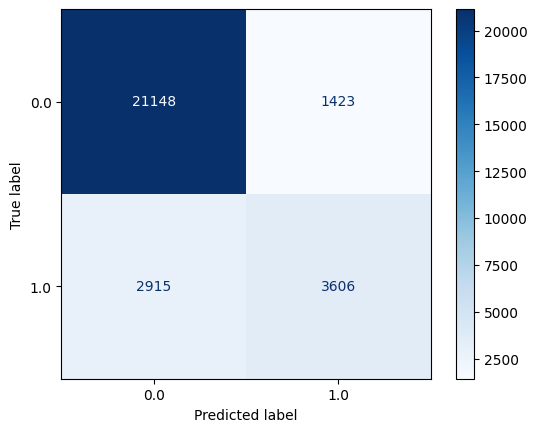

<Figure size 1200x1200 with 0 Axes>

In [26]:
cm=confusion_matrix(y_test, y_pred_byhand)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [27]:
print(classification_report(y_test, y_pred_byhand))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     22571
         1.0       0.72      0.55      0.62      6521

    accuracy                           0.85     29092
   macro avg       0.80      0.74      0.77     29092
weighted avg       0.84      0.85      0.84     29092



In [28]:
recall = recall_score(y_test, y_pred_byhand, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.5529826713694219
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9369544991360595


### 2.2 Resampled

In [29]:
# Đưa tập dữ liệu từ dạng pd về np.array
X_train_resampled = np.array(X_train_resampled)
y_train_resampled = np.array(y_train_resampled)
# lưu chiều ma trận train model
m, n = X_train_resampled.shape

# Thêm một cột giá trị bias 1
X_train_resampled = np.concatenate([np.ones((m, 1)), X_train_resampled], axis=1)
print(m)
print(n)

101569
23


In [30]:
# Sử dụng BGD để minimize cost function
alpha = 0.01  # Learning rate
num_iters = 2000  # Số lần lặp tối đa
initial_theta = np.zeros(n + 1)
batch_size=1024
theta, cost, history  = mini_batch_gradient_descent( X_train_resampled, y_train_resampled, initial_theta, alpha, num_iters, batch_size)

print("Optimal theta:", theta)
print("Final cost:", cost)

Iteration 0: Cost = 0.6931471805599312
Iteration 100: Cost = 0.5298463380208958
Iteration 200: Cost = 0.488209154335193
Iteration 300: Cost = 0.4818525726422299
Iteration 400: Cost = 0.4485950086288881
Iteration 500: Cost = 0.4821093986566524
Iteration 600: Cost = 0.43581063294763017
Iteration 700: Cost = 0.4526111969784961
Iteration 800: Cost = 0.4613291522609047
Iteration 900: Cost = 0.46712038520428517
Iteration 1000: Cost = 0.4618706483308197
Iteration 1100: Cost = 0.4267982110228715
Iteration 1200: Cost = 0.4411543120057743
Iteration 1300: Cost = 0.42842458797930993
Iteration 1400: Cost = 0.4224560563798002
Iteration 1500: Cost = 0.4371198646312062
Iteration 1600: Cost = 0.4153629016979885
Iteration 1700: Cost = 0.42308440325817837
Iteration 1800: Cost = 0.4376453367297266
Iteration 1900: Cost = 0.44384575962615475
Optimal theta: [-0.2609582  -0.01271819  0.09146574  0.00142484  0.16156947 -0.06688939
 -0.5240032   0.02450658  0.33411519 -0.10361604 -0.08708456 -0.01590768
 -0.001

In [31]:
m, n = X_test_resampled.shape
X_test_byhand = np.concatenate([np.ones((m, 1)), X_test_resampled], axis=1)

In [32]:
# Tính toán giá trị dự đoán
start_time = time.time()
y_pred_byhand = predict(theta, X_test_byhand)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc=accuracy_score(y_test, y_pred_byhand)*100
result_acc.append(acc)
print('Test Accuracy: {:.2f} %'.format(acc))



Time to predict: 0.2449 seconds
Test Accuracy: 80.29 %


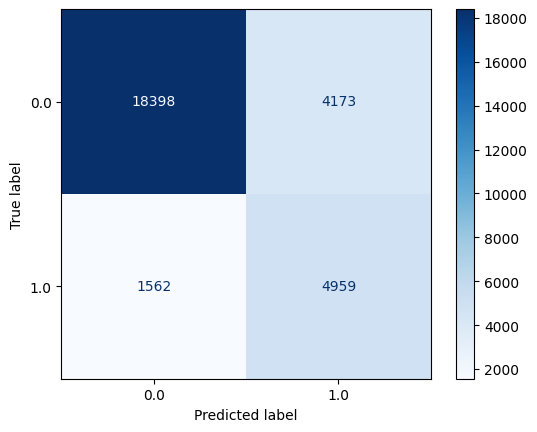

<Figure size 1200x1200 with 0 Axes>

In [33]:
cm=confusion_matrix(y_test, y_pred_byhand)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [34]:
print(classification_report(y_test, y_pred_byhand))

              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     22571
         1.0       0.54      0.76      0.63      6521

    accuracy                           0.80     29092
   macro avg       0.73      0.79      0.75     29092
weighted avg       0.84      0.80      0.81     29092



In [35]:
recall = recall_score(y_test, y_pred_byhand, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.7604661861677657
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.8151167427229631


## 3. Model comparing

In [36]:
result_acc

[85.56304138594803, 82.60690224116595, 85.08868417434347, 80.28667674962189]

In [37]:
result_recall

[array([94.22710558, 55.57429842]), array([84.51552878, 76.0006134 ])]

In [38]:
pred_time

[0.006824970245361328,
 0.005041360855102539,
 0.12889814376831055,
 0.2449188232421875]

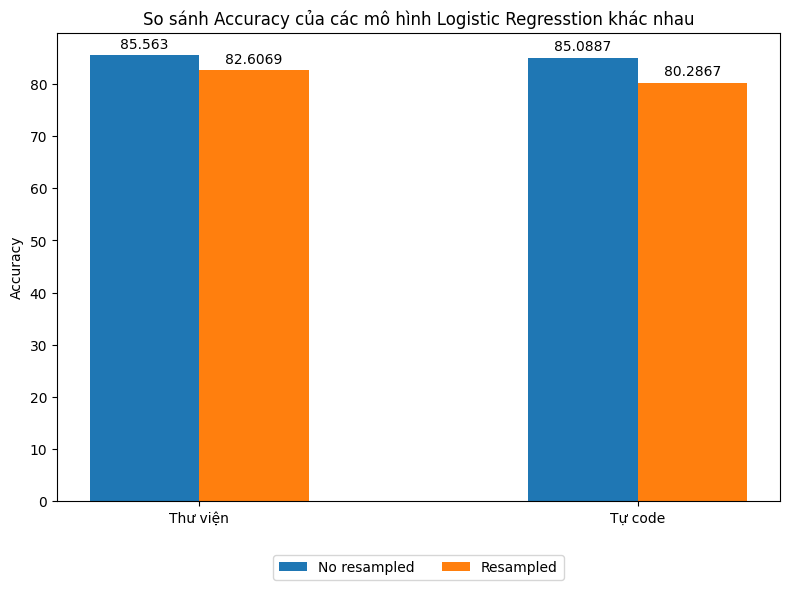

In [39]:
labels = ['Thư viện', 'Tự code']
no_res = [result_acc[0], result_acc[2]]
res = [result_acc[1], result_acc[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('So sánh Accuracy của các mô hình Logistic Regresstion khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

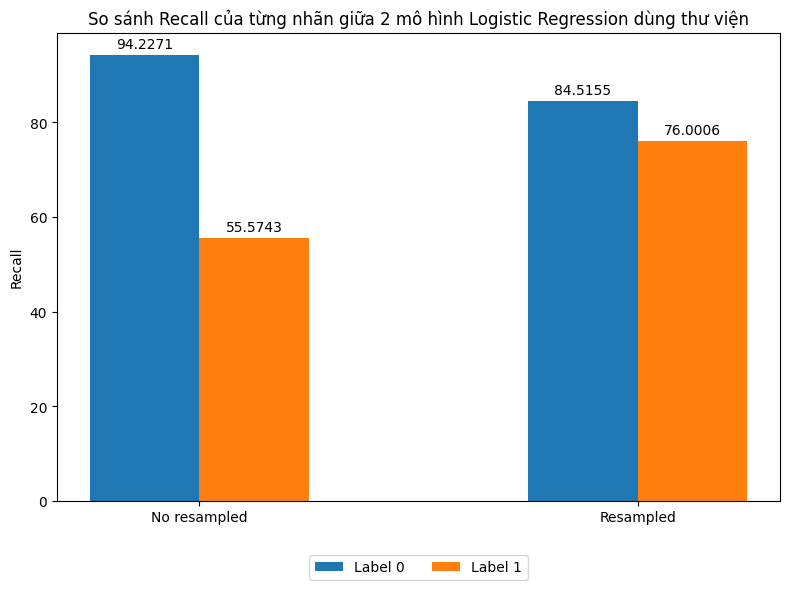

In [40]:
labels = ['No resampled', 'Resampled']
label_0 = [result_recall[0][0], result_recall[1][0]]
label_1 = [result_recall[0][1], result_recall[1][1]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, label_0, width, label='Label 0')
rects2 = ax.bar(x + width/2, label_1, width, label='Label 1')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Recall')
ax.set_title('So sánh Recall của từng nhãn giữa 2 mô hình Logistic Regression dùng thư viện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

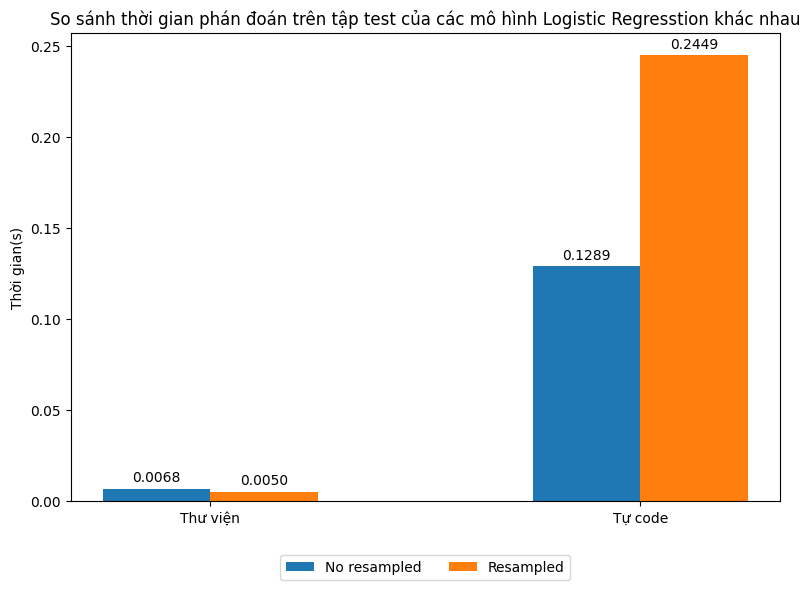

In [41]:
labels = ['Thư viện', 'Tự code']
no_res = [pred_time[0], pred_time[2]]
res = [pred_time[1], pred_time[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Thời gian(s)')
ax.set_title('So sánh thời gian phán đoán trên tập test của các mô hình Logistic Regresstion khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3, labels=[f"{value:.4f}" for value in no_res])
ax.bar_label(rects2, padding=3, labels=[f"{value:.4f}" for value in res])

fig.tight_layout()

plt.show()

In [43]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Result/Model_Evaluation/1. Logistic Regression.pkl'
with open(file_path, 'wb') as f:
    pickle.dump([result_acc,result_recall,pred_time],f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
